# Import libraries

In [1]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc

import matplotlib.pyplot as plt
%matplotlib inline
import statistics
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

In [2]:
import rasterio
from rasterio.windows import Window

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

# Configuration 

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seeds();

In [5]:
DATA_PATH = 'hubmap-kidney-segmentation/hubmap-kidney-segmentation_original'
EPOCHS =20
BATCH_SIZE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

# UDF

In [6]:
# used for converting the decoded image to rle mask
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

@numba.njit()     # https://numba.pydata.org/numba-doc/latest/user/5minguide.html
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1:
        flag = False
        points.append(1)
    else:
        flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [7]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

class HubDataset(D.Dataset):

    def __init__(self, root_dir, transform,
                 window=256, overlap=64, threshold = 500):
        self.path = pathlib.Path(root_dir)
        self.overlap = overlap
        self.window = window
        self.transform = transform
        self.csv = pd.read_csv((self.path / 'train.csv').as_posix(),
                               index_col=[0])
        self.threshold = threshold
        self.build_slices()
        self.len = len(self.slices)
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        for i, filename in enumerate(self.csv.index.values):
            filepath = (self.path /'train'/(filename+'.tiff')).as_posix()
            self.files.append(filepath)
            with rasterio.open(filepath, transform = identity) as dataset:
                self.masks.append(rle_decode(
                    self.csv.loc[filename, 'encoding'], dataset.shape))
                slices = make_grid(dataset.shape, window=self.window,
                                   min_overlap=self.overlap)
                for slc in slices:
                    x1,x2,y1,y2 = slc
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold:
                        self.slices.append([i,x1,x2,y1,y2])
                        
    # get data operation
    def __getitem__(self, index):
        
        idx = self.slices[index][0]
        filename = self.files[idx]
        x1,x2,y1,y2 = self.slices[index][1:] 
        with rasterio.open(filename, transform = identity) as dataset:
            channels = [1,2,3] if dataset.count == 3 else [1,1,1]
            image = dataset.read(channels,window=Window.from_slices((x1,x2),(y1,y2)))    
            image = np.moveaxis(image, 0, -1)
            
        mask = self.masks[idx][x1:x2,y1:y2]
        
        augments = self.transform(image=image, mask=mask)
        return self.as_tensor(augments['image']), augments['mask'][None]
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

# Data

## Data Cleaning

In [8]:
HuBMAP_DS_information = pd.read_csv(DATA_PATH+"/HuBMAP-20-dataset_information.csv") 
df_info=HuBMAP_DS_information
df_info_idx= []
list1=["57512b7f1.tiff","3589adb90.tiff","aa05346ff.tiff","2ec3f1bb9.tiff","d488c759a.tiff"]
for i in range(len(df_info)):
    if df_info["image_file"][i] in list1:
        df_info_idx.append(i)
df_info_idx
df_info=df_info.drop(df_info.index[df_info_idx])
len(df_info)

15

## Data processing

In [9]:
WINDOW=1024
MIN_OVERLAP=32
NEW_SIZE=256

trfm = A.Compose([
    A.Resize(NEW_SIZE,NEW_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter (brightness=0.07, contrast=0.07,
                   saturation=0.1, hue=0.1, always_apply=False, p=0.3)
])

ds = HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

## Split train, validation and test

In [10]:
valid_idx, train_idx, test_idx = [], [], []
for i in range(len(ds)):
    if ds.slices[i][0] == 4 :
        valid_idx.append(i)
    else:
        if ds.slices[i][0] == 8:
            test_idx.append(i)
        else:
            train_idx.append(i)
            
train_ds = D.Subset(ds, train_idx)
valid_ds = D.Subset(ds, valid_idx)
test_ds = D.Subset(ds, test_idx)
print("train_size: ",len(train_idx), "\nvalidation_size: ",len(valid_idx),"\ntest_size: ",len(test_idx) )

train_size:  3255 
validation_size:  349 
test_size:  417


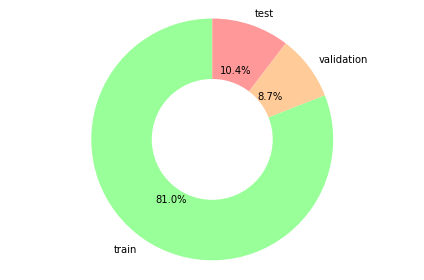

In [11]:
import matplotlib.pyplot as plt
# Pie chart
labels = ['train', 'validation','test']
sizes = [len(train_idx), len(valid_idx),  len(test_idx)]
#colors
colors = ['#99ff99' ,'#ffcc99', '#ff9999','#66b3ff']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [12]:
# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
tloader = D.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Input data visualization

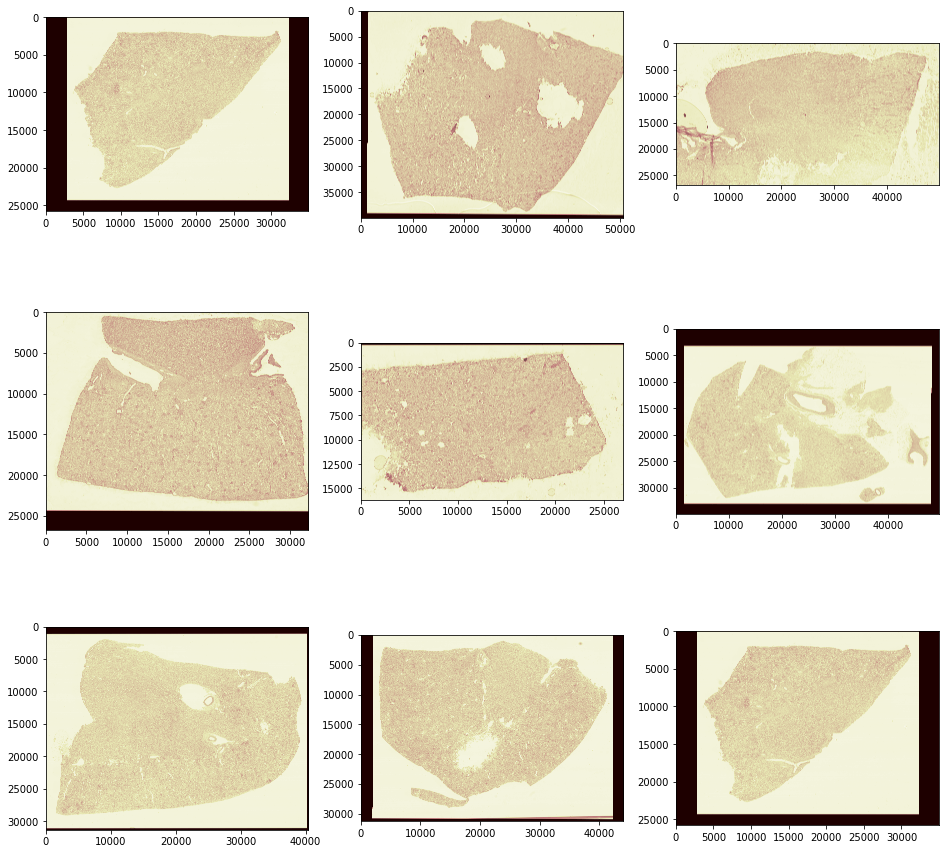

In [96]:
from matplotlib import pyplot

plt.figure(figsize=(16, 16))

plt.subplot(3, 3, 1)
ImagePath=DATA_PATH+'/train/0486052bb.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(3, 3, 2)
ImagePath=DATA_PATH+'/train/4ef6695ce.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(3, 3, 3)
ImagePath=DATA_PATH+'/train/c68fe75ea.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')


plt.subplot(3, 3, 4)
ImagePath=DATA_PATH+'/train/1e2425f28.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(3, 3, 5)
ImagePath=DATA_PATH+'/train/e79de561c.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(3, 3, 6)
ImagePath=DATA_PATH+'/train/cb2d976f4.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(3, 3, 7)
ImagePath=DATA_PATH+'/train/b9a3865fc.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(3, 3, 8)
ImagePath=DATA_PATH+'/train/8242609fa.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

plt.subplot(3, 3, 9)
ImagePath=DATA_PATH+'/train/0486052bb.tiff'
src = rasterio.open(ImagePath)
pyplot.imshow(src.read(1), cmap='pink')

pyplot.show()

In [54]:
df_info

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
1,afa5e8098.tiff,43780,36800,afa5e8098-anatomical-structure.json,afa5e8098.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
2,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
4,1e2425f28.tiff,32220,26780,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35
5,e79de561c.tiff,27020,16180,e79de561c-anatomical-structure.json,e79de561c.json,67026,Black or African American,Not Hispanic or Latino,Male,53,73.0,166.0,26.5,Left,55,45
6,c68fe75ea.tiff,49780,26840,c68fe75ea-anatomical-structure.json,c68fe75ea.json,67112,White,Not Hispanic or Latino,Male,56,91.2,167.6,32.5,Left,80,20
7,095bf7a1f.tiff,39000,38160,095bf7a1f-anatomical-structure.json,095bf7a1f.json,68250,White,Not Hispanic or Latino,Female,44,71.7,160.0,28.0,Right,65,35
8,26dc41664.tiff,42360,38160,26dc41664-anatomical-structure.json,26dc41664.json,68304,White,Not Hispanic or Latino,Female,66,71.3,167.6,25.4,Left,55,45
10,4ef6695ce.tiff,50680,39960,4ef6695ce-anatomical-structure.json,4ef6695ce.json,66999,White,Not Hispanic or Latino,Male,56,91.4,181.6,27.7,Right,65,35
11,aaa6a05cc.tiff,13013,18484,aaa6a05cc-anatomical-structure.json,aaa6a05cc.json,65631,White,Not Hispanic or Latino,Female,73,NaN,NaN,NaN,Left,75,25
12,b9a3865fc.tiff,40429,31295,b9a3865fc-anatomical-structure.json,b9a3865fc.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45


<AxesSubplot:xlabel='weight_kilograms', ylabel='Count'>

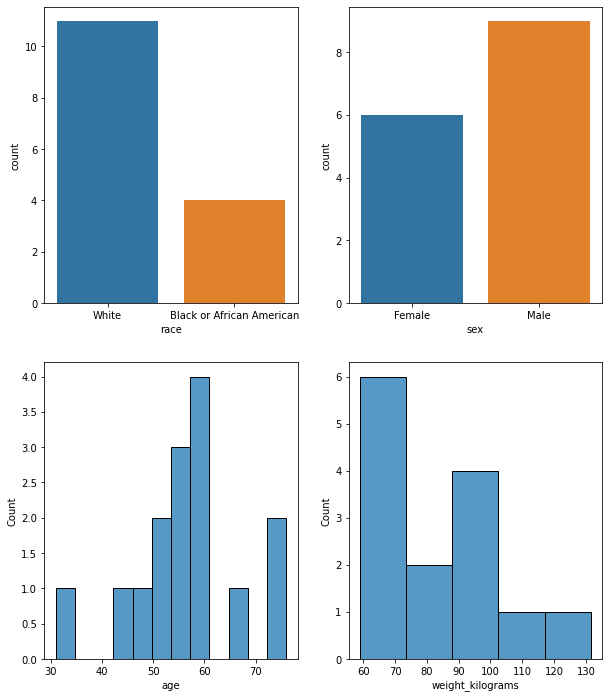

In [14]:
import seaborn as sn
plt.figure(figsize=(10, 12))
plt.subplot(2, 2, 1)
sn.countplot(x="race", data=df_info)
plt.subplot(2, 2, 2)
sn.countplot(x="sex", data=df_info)
plt.subplot(2, 2, 3)
sn.histplot(x="age", data=df_info)
plt.subplot(2, 2, 4)
sn.histplot(x="weight_kilograms", data=df_info)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


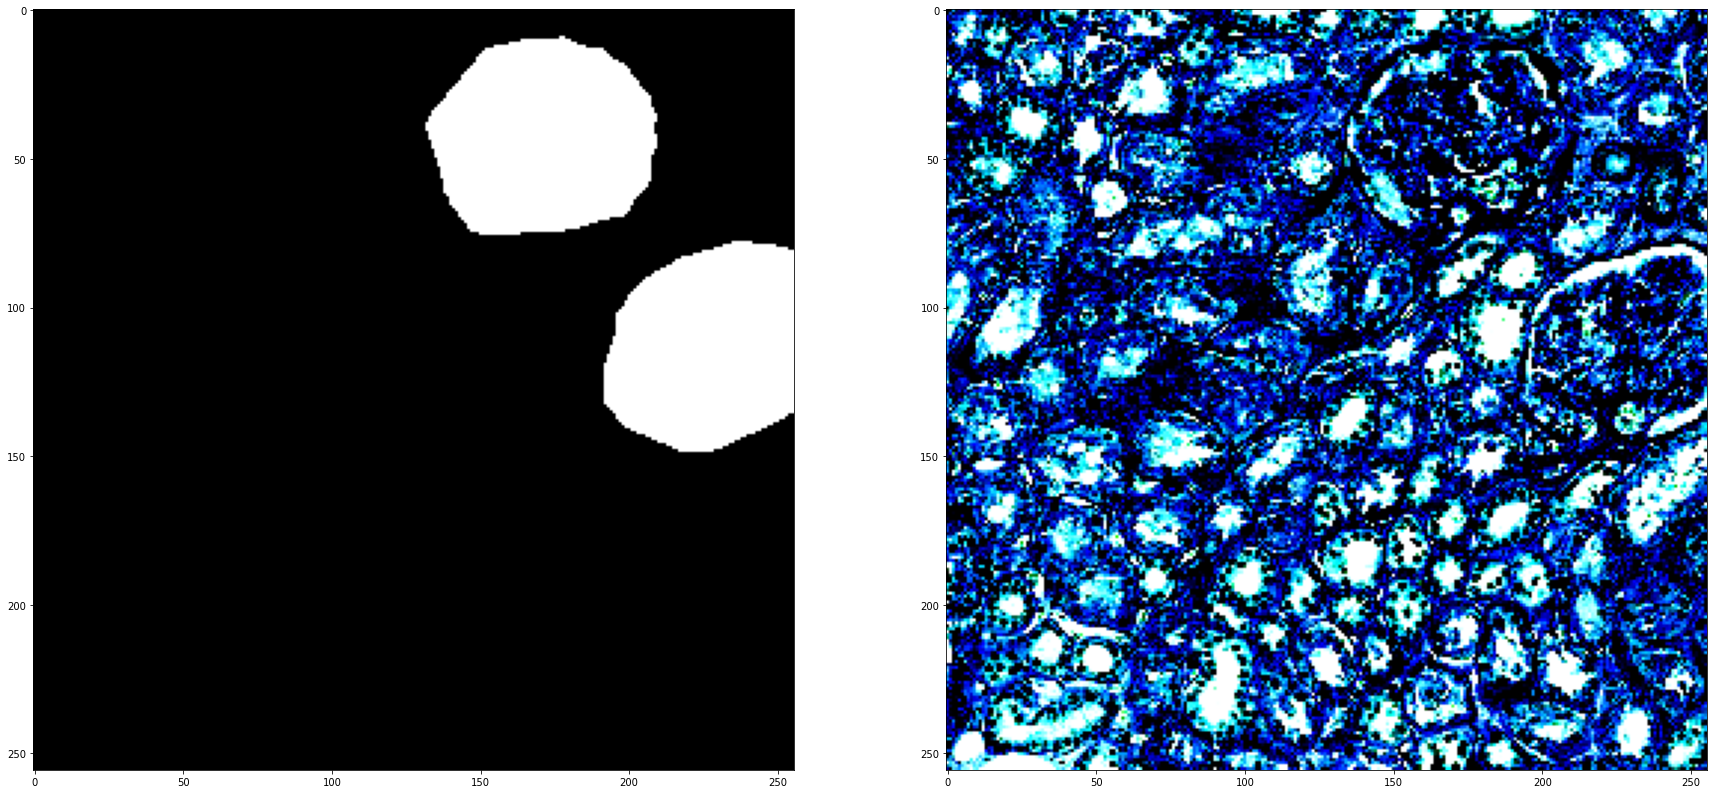

In [13]:
image, mask = ds[350]
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
#plt.imshow(mask[0])
plt.imshow(mask[0], cmap='gray')

plt.subplot(1,2,2)
img=image
img=img.permute(1, 2, 0)
plt.imshow(img)
#plt.imshow(img)
#plt.imshow(image[0]);
mask_rle = rle_numba_encode(mask[0]) # compile function with numba

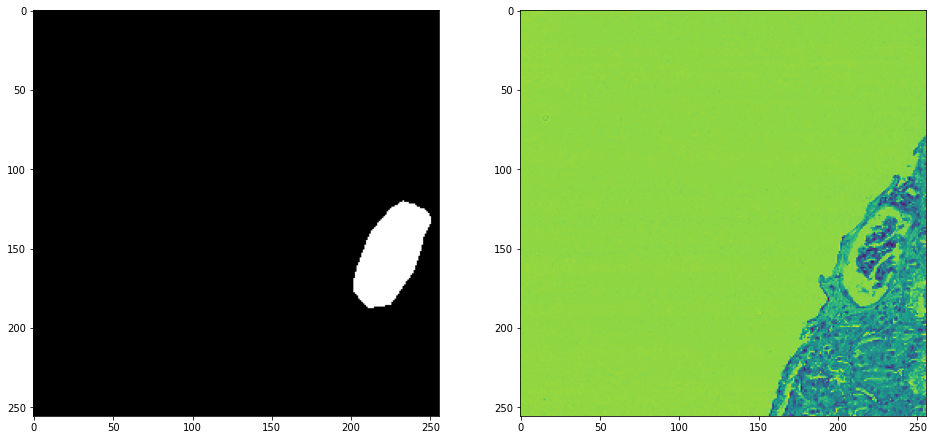

In [14]:
image, mask = ds[1]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);
mask_rle = rle_numba_encode(mask[0]) # compile function with numba

In [17]:
mask 

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [18]:
mask_rle

'51882 9 52134 14 52386 19 52640 23 52893 27 53146 31 53400 34 53653 38 53906 42 54160 45 54414 47 54668 49 54923 50 55178 50 55433 51 55687 53 55942 54 56197 55 56452 56 56707 57 56962 57 57216 59 57471 60 57726 61 57981 60 58237 59 58492 59 58748 57 59003 57 59258 56 59514 55 59769 54 60026 52 60282 50 60538 49 60795 47 61051 45 61307 44 61563 42 61820 38 62077 34 62333 31 62590 27 62846 23 63102 18 63359 15 63616 12 63873 9 64131 5'

# Model 

In [19]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

In [20]:
model = get_model()
model.to(DEVICE);
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

In [21]:
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [22]:
@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    dice_values = []

    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        dice =1- dice_fn(output.sigmoid(), target)
        losses.append(loss.item())
        dice_values.append(dice.item())
        
    return np.array(losses).mean(),np.array(dice_values).mean()

In [23]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc

In [24]:
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice

## train model

In [25]:
### Table for results
header = r'''
        Train         | Valid
Epoch |  Loss |  dice |  Loss |  dice | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*4 + '\u2502{:6.2f}'

In [26]:
print(header)
epochs=[]
TrainLoss=[]
TrainDice=[]
ValidLoss=[]
ValidDice=[]
TrainLossMedian=[]
TrainDiceMedian=[]
times=[]

for epoch in range(1, EPOCHS+1):
    losses = []
    dice_values=[]
  
    start_time = time.time()
    model.train()
    for image, target in loader:
        i=0
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = loss_fn(output, target)
        dice = 1- dice_fn(output.sigmoid(), target)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        dice_values.append(dice.item())
        
    vloss,vdice= validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(),np.array(dice_values).mean(), vloss,vdice,
                              (time.time()-start_time)/60**1))    
    epochs.append(epoch)
    TrainLoss.append(np.array(losses).mean())
    TrainDice.append(np.array(dice_values).mean())
    TrainLossMedian.append(statistics.median(np.array(losses)))
    TrainDiceMedian.append(statistics.median(np.array(dice_values)))
    ValidLoss.append(vloss)
    ValidDice.append(vdice)
    times.append((time.time()-start_time)/60**1)

    losses = []
    dice_values= []


        Train         | Valid
Epoch |  Loss |  dice |  Loss |  dice | Time, m

     1│  0.197│  0.528│  0.085│  0.759│  6.46
     2│  0.088│  0.744│  0.067│  0.821│  6.44
     3│  0.070│  0.803│  0.054│  0.866│  6.46
     4│  0.063│  0.827│  0.051│  0.872│  6.47
     5│  0.058│  0.841│  0.054│  0.870│  6.50
     6│  0.050│  0.862│  0.053│  0.880│  6.45
     7│  0.051│  0.863│  0.053│  0.879│  6.54
     8│  0.047│  0.875│  0.048│  0.892│  6.52
     9│  0.044│  0.879│  0.050│  0.890│  6.51
    10│  0.044│  0.884│  0.050│  0.889│  6.52
    11│  0.043│  0.885│  0.050│  0.892│  6.51
    12│  0.041│  0.891│  0.051│  0.885│  6.50
    13│  0.040│  0.894│  0.049│  0.894│  6.53
    14│  0.037│  0.901│  0.052│  0.891│  6.52
    15│  0.039│  0.897│  0.052│  0.891│  6.49
    16│  0.036│  0.906│  0.054│  0.884│  6.46
    17│  0.037│  0.903│  0.054│  0.890│  6.50
    18│  0.037│  0.903│  0.051│  0.897│  6.51
    19│  0.034│  0.909│  0.053│  0.890│  6.51
    20│  0.034│  0.911│  0.055│  0.885│  6.40


## Model output visualization

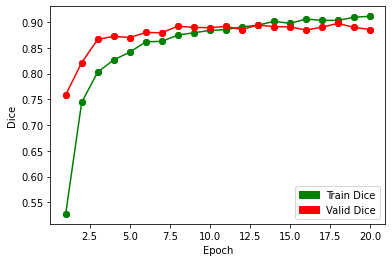

In [75]:
x = epochs
y=TrainDice
z = ValidDice
t=TrainDiceMedian
plt.plot(x,y, 'o', color='green');
plt.plot(x, y, '-ok', color='green');
plt.plot(x, z, 'o', color='red');
plt.plot(x, z, '-ok', color='red');

trainDice = mpatches.Patch(color='green', label='Train Dice')
validDice = mpatches.Patch(color='red', label='Valid Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend(handles=[trainDice,validDice])

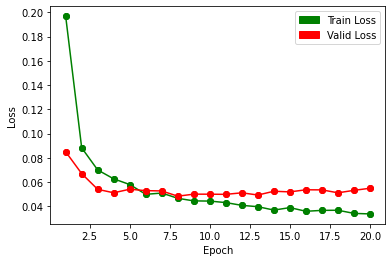

In [77]:
x = epochs
y=TrainLoss
z=ValidLoss
u=TrainLossMedian
plt.plot(x, y, 'o', color='green');
plt.plot(x, y, '-ok', color='green');
plt.plot(x, z, 'o', color='red');
plt.plot(x, z, '-ok', color='red')

trainLoss = mpatches.Patch(color='green', label='Train Loss')
validLoss = mpatches.Patch(color='red', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(handles=[trainLoss,validLoss])

In [34]:
epochs

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [35]:
times

[6.455233446756998,
 6.440150356292724,
 6.46369256178538,
 6.467632599671682,
 6.4955469806989035,
 6.445120028654734,
 6.539895296096802,
 6.515225025018056,
 6.506721671422323,
 6.519381296634674,
 6.507967444260915,
 6.498393265406291,
 6.529813313484192,
 6.520570898056031,
 6.490480915705363,
 6.455219173431397,
 6.501272654533386,
 6.505885263284047,
 6.505389352639516,
 6.399746568997701]

In [36]:
ValidDice

[0.7585050314664841,
 0.8213002356615934,
 0.8662306747653268,
 0.8722431348128752,
 0.8699255070903085,
 0.8797258152203127,
 0.8792263919656927,
 0.8920169581066478,
 0.8896389779719439,
 0.8890734978697516,
 0.8915222544561733,
 0.8853453072634611,
 0.8942934464324604,
 0.89094031940807,
 0.8905849483880129,
 0.8844803165305745,
 0.8899839154698632,
 0.8973949565128847,
 0.8895662887529894,
 0.8854954798113216]

In [37]:
ValidLoss

[0.08502826551822099,
 0.06698314845561981,
 0.05401766736229712,
 0.05117254086177458,
 0.054119503548876804,
 0.05294046639888124,
 0.05270183585922827,
 0.04836945011365143,
 0.05005002614449371,
 0.05001283331181516,
 0.04988266349854795,
 0.05115153052082116,
 0.04932831079614433,
 0.05243552192537622,
 0.05191828636452556,
 0.053650030781599606,
 0.053577386858788406,
 0.0511539724486118,
 0.05319547466933727,
 0.05491911378604444]

In [38]:
TrainDice

[0.5275481892452193,
 0.7441005907421909,
 0.8028420458847533,
 0.8266571684024258,
 0.8414468921958961,
 0.8616662183616319,
 0.8625162943868145,
 0.8747674160858923,
 0.8791992252816146,
 0.8837173690959921,
 0.8853626741824044,
 0.890587047071949,
 0.8937432571183844,
 0.9013988347838493,
 0.8974382894923705,
 0.9056721672379121,
 0.9032798046269054,
 0.9032442823089019,
 0.9092903061053677,
 0.9112614388840791]

In [39]:
TrainDiceMedian

[0.5493335723876953,
 0.7550066113471985,
 0.8087379932403564,
 0.8402971029281616,
 0.8570340871810913,
 0.8839112520217896,
 0.8801637887954712,
 0.8947718143463135,
 0.9040435552597046,
 0.906807541847229,
 0.9061441421508789,
 0.9133927226066589,
 0.9137512445449829,
 0.9215518236160278,
 0.9173181056976318,
 0.9245603084564209,
 0.9220057725906372,
 0.9229124784469604,
 0.929236888885498,
 0.9278559684753418]

In [40]:
TrainLoss

[0.19680765318782675,
 0.08826970736466402,
 0.07000177317923645,
 0.06266811038356009,
 0.05797950257100989,
 0.04989893142252941,
 0.050962035001898574,
 0.046624212445695805,
 0.04448510803447016,
 0.04433476100664321,
 0.04307889151192414,
 0.04080123332139168,
 0.039695605457158584,
 0.036901501087467266,
 0.038947248854273954,
 0.03591148916824151,
 0.03666540453581171,
 0.03676892568972831,
 0.03416805591260332,
 0.03374443928132186]

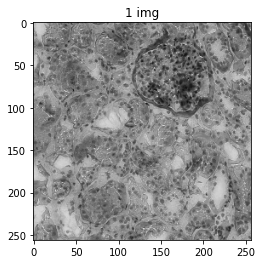

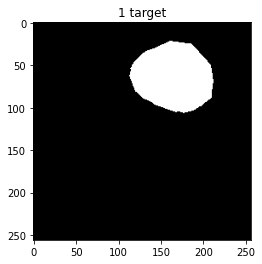

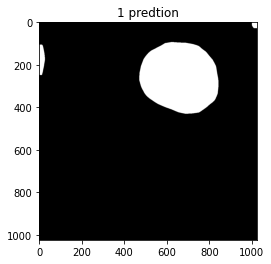

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


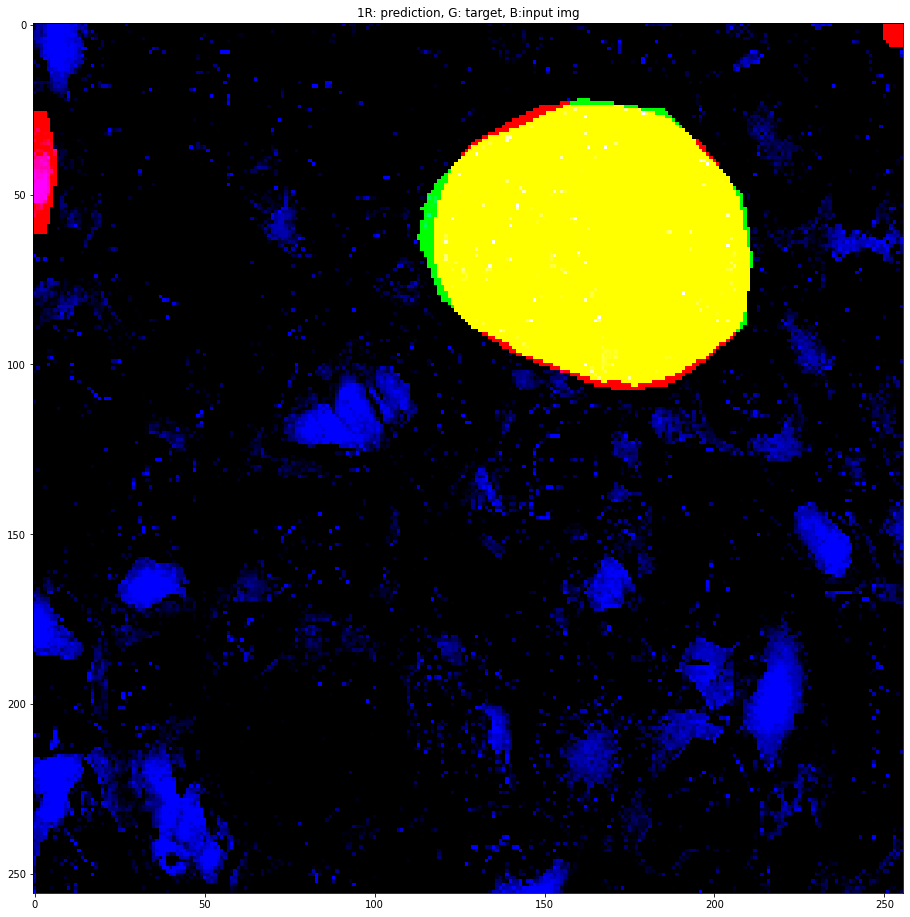

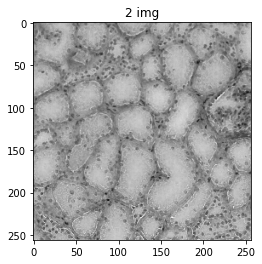

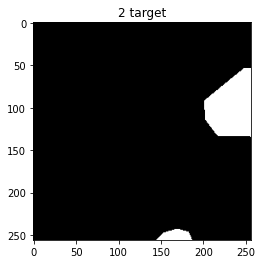

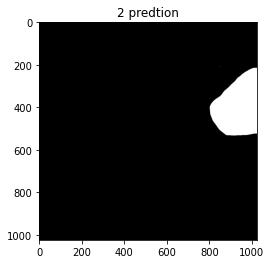

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


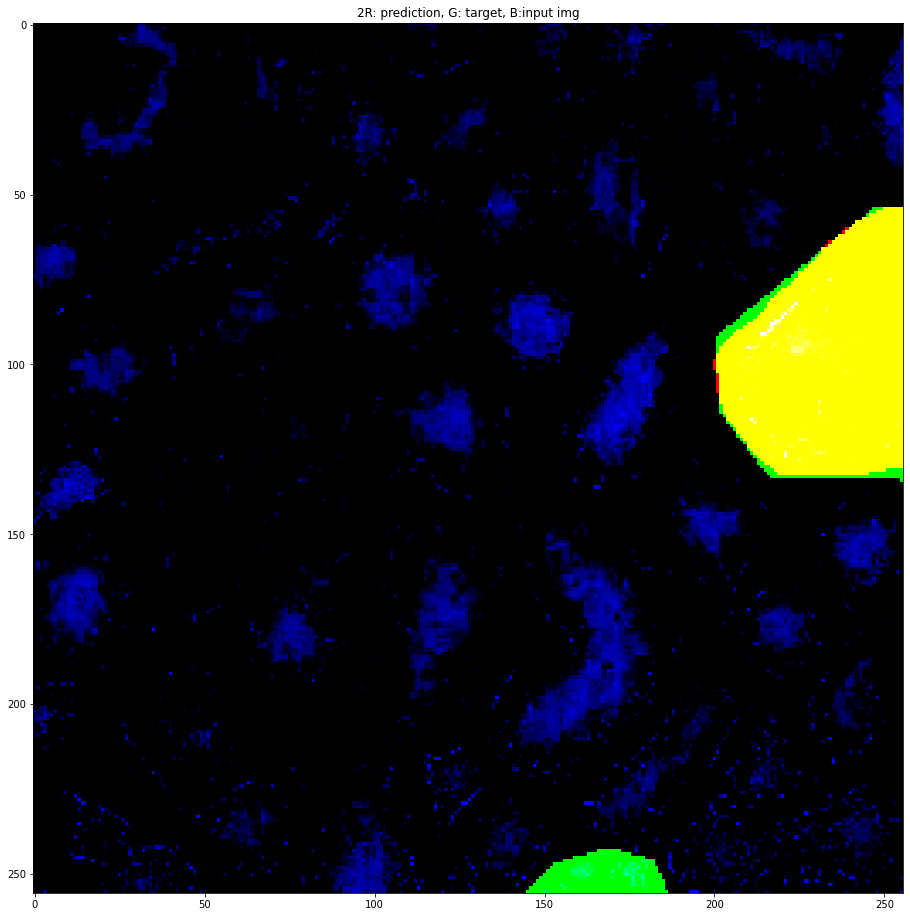

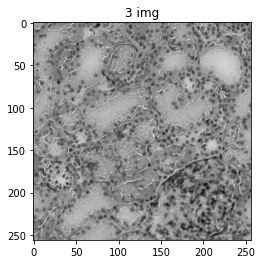

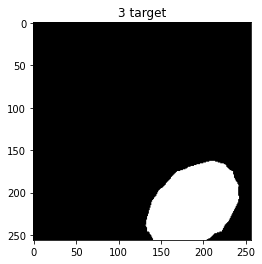

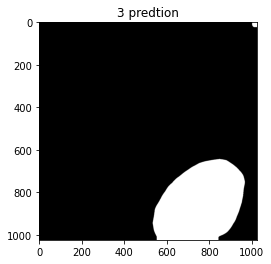

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


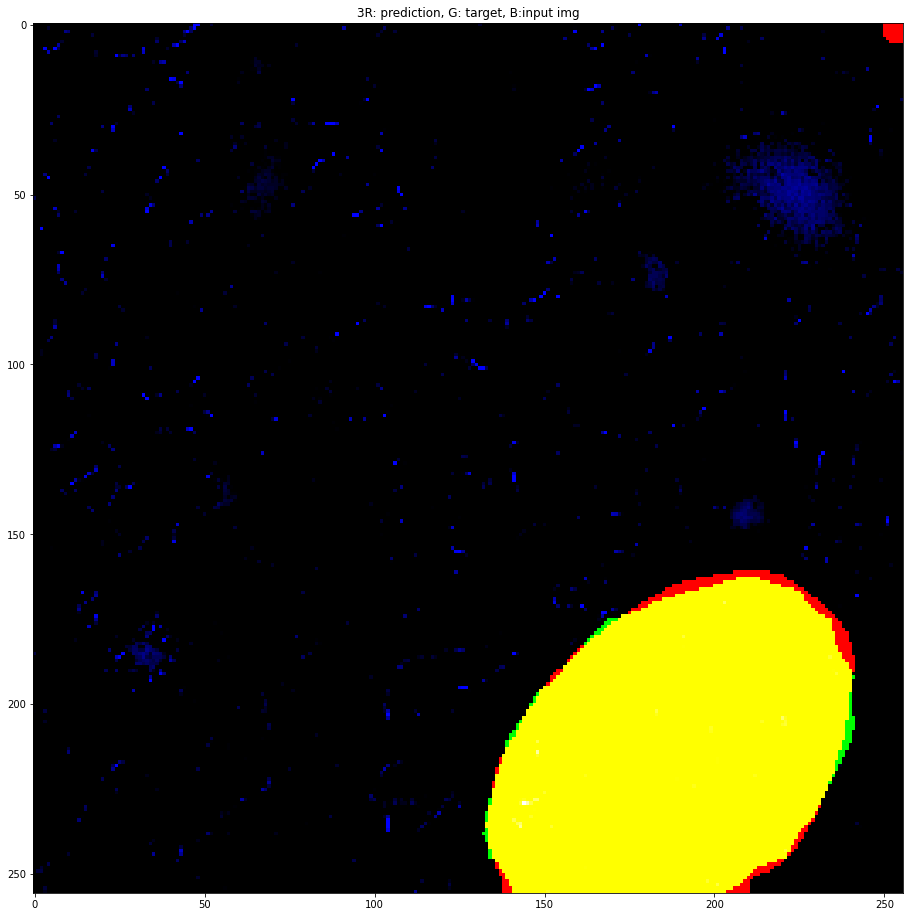

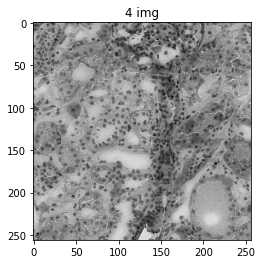

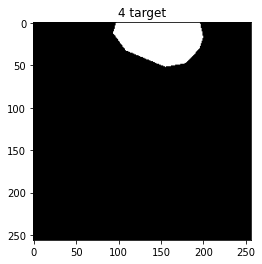

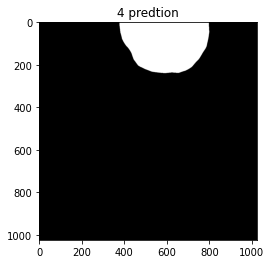

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


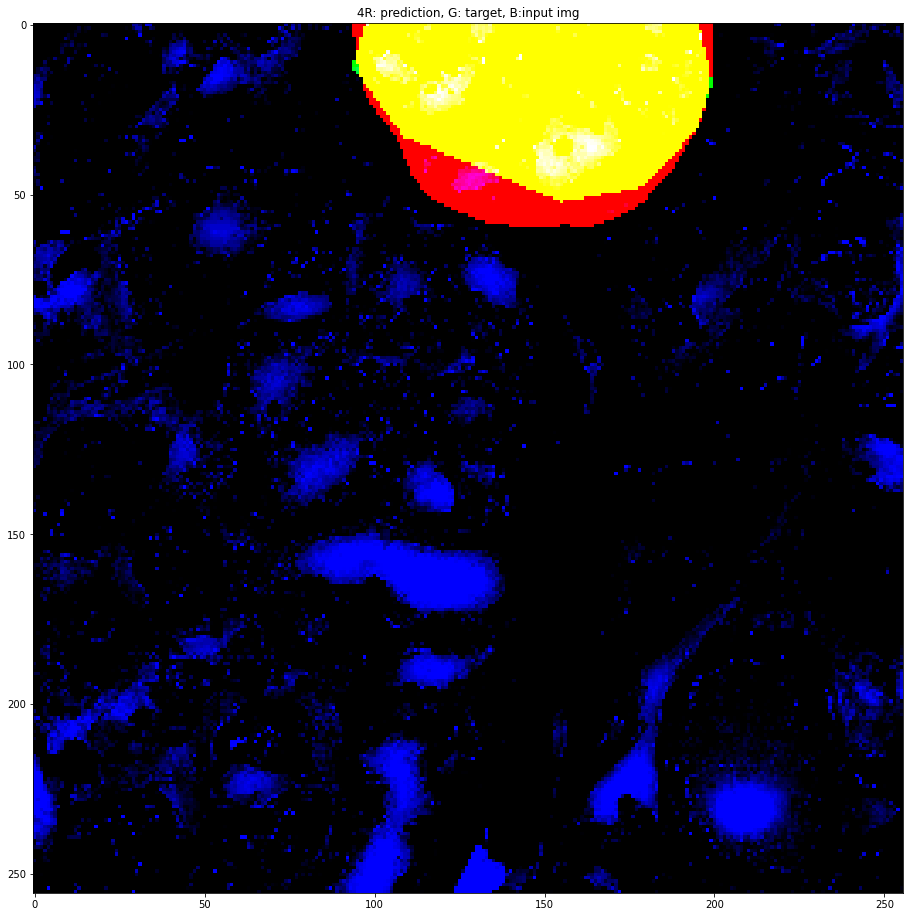

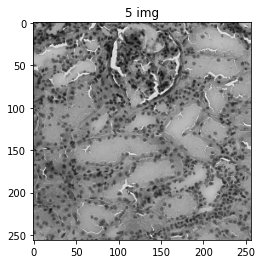

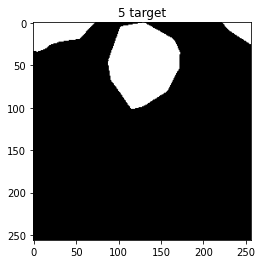

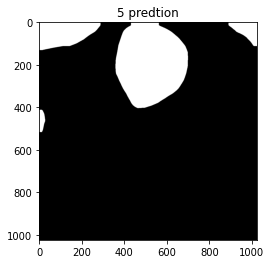

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


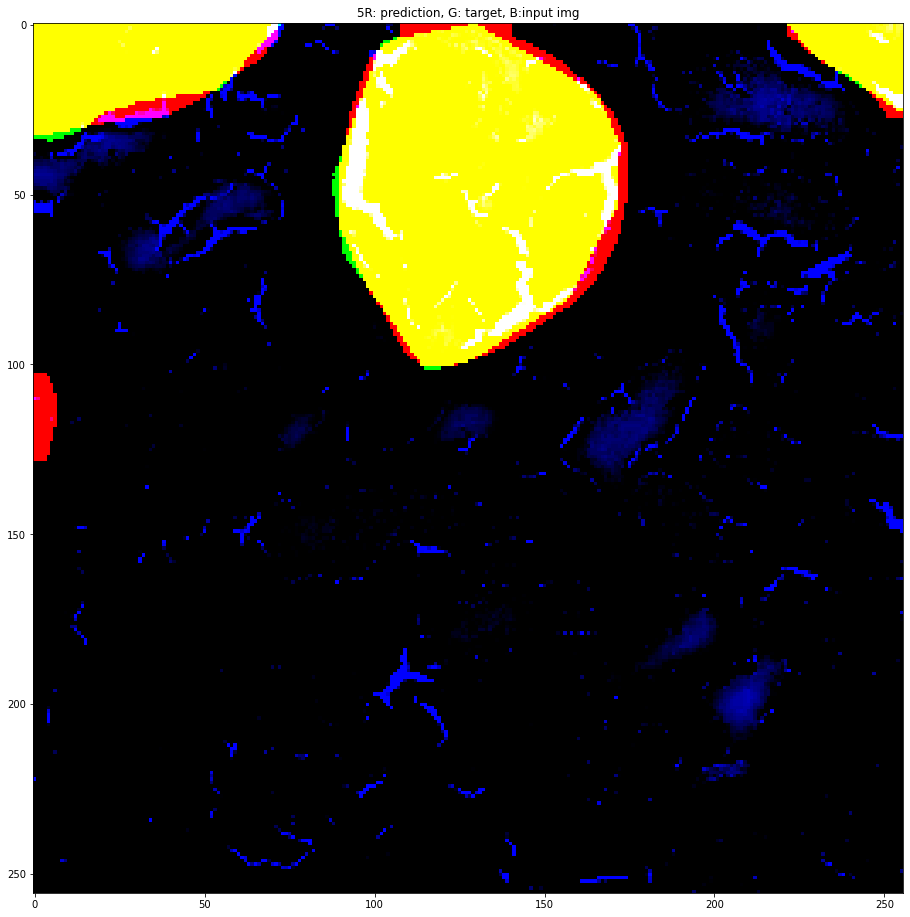

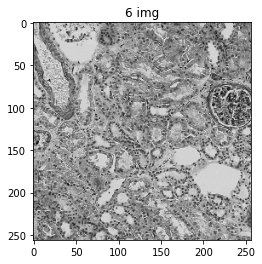

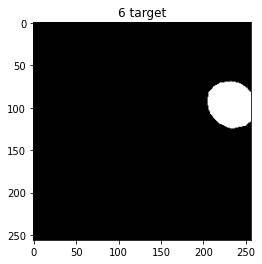

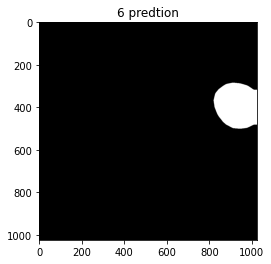

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


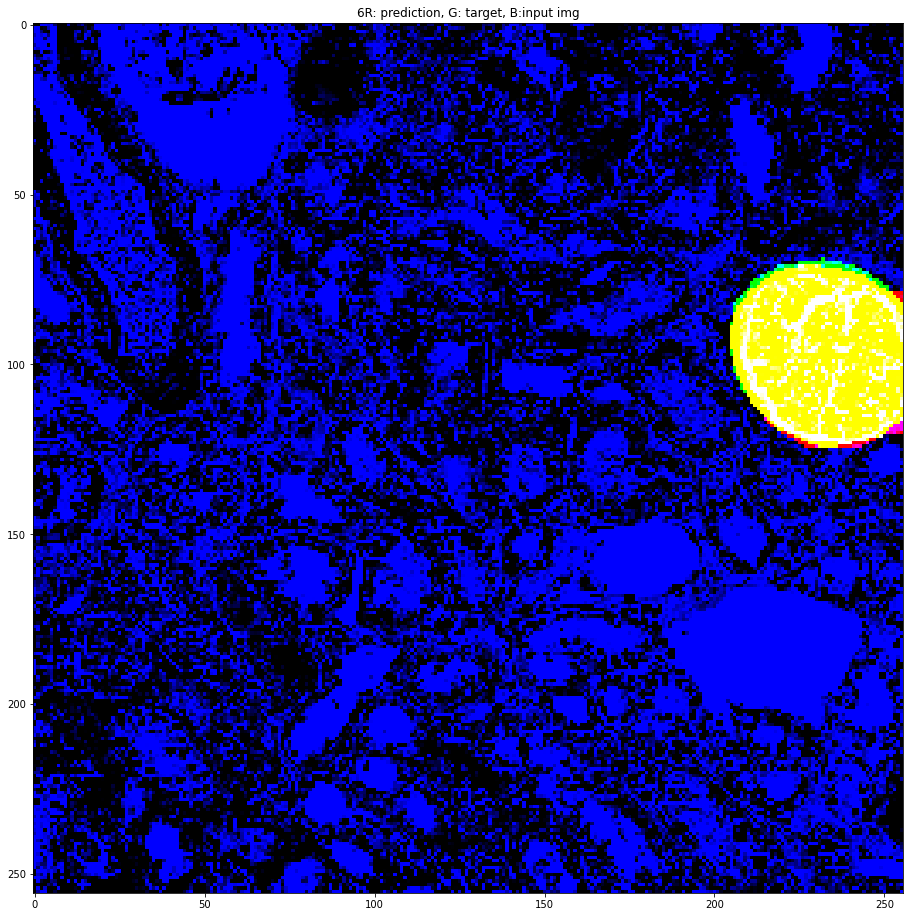

In [41]:
i=0

for image, target in loader:
        i+=1  
        
        plt.imshow(image[0][0], cmap='gray')
        plt.title(str(i)+' img')
        plt.show()
        

        plt.imshow(target[0][0], cmap='gray')
        plt.title(str(i)+' target')
        plt.show()
        
        image = image.to(DEVICE)
        target = target.float().to(DEVICE)
        
        with torch.no_grad():
            #score = model(image.to(DEVICE)[None])['out'][0][0] # output = model(image)['out']
            score = model(image)['out'][0][0] # output = model(image)['out']
            score = score.cpu().numpy()
            score = cv2.resize(score, (WINDOW, WINDOW))
            predtion = (score > 0).astype(np.uint8)
            
            
            plt.imshow(predtion, cmap='gray')
            plt.title(str(i)+' predtion')
            plt.show()
        
        
            pred = cv2.resize(predtion, (256, 256)) #predtion.cpu().numpy() #((predtion)+img.min())/img.max()*250
            print(image[0].shape)
            img = image[0].cpu().numpy() #np.moveaxis(image[0], 0,-1)
            img[0,:,:] = pred
            img[1,:,:] = target[0][0].cpu().numpy()
            #img = np.transpose(img)
            img = np.moveaxis(img, 0, -1) #.shape
            plt.figure(figsize=(16,16))
            plt.imshow(img)
            plt.title(str(i)+'R: prediction, G: target, B:input img')
            plt.show()


        if i>5:
            break;     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


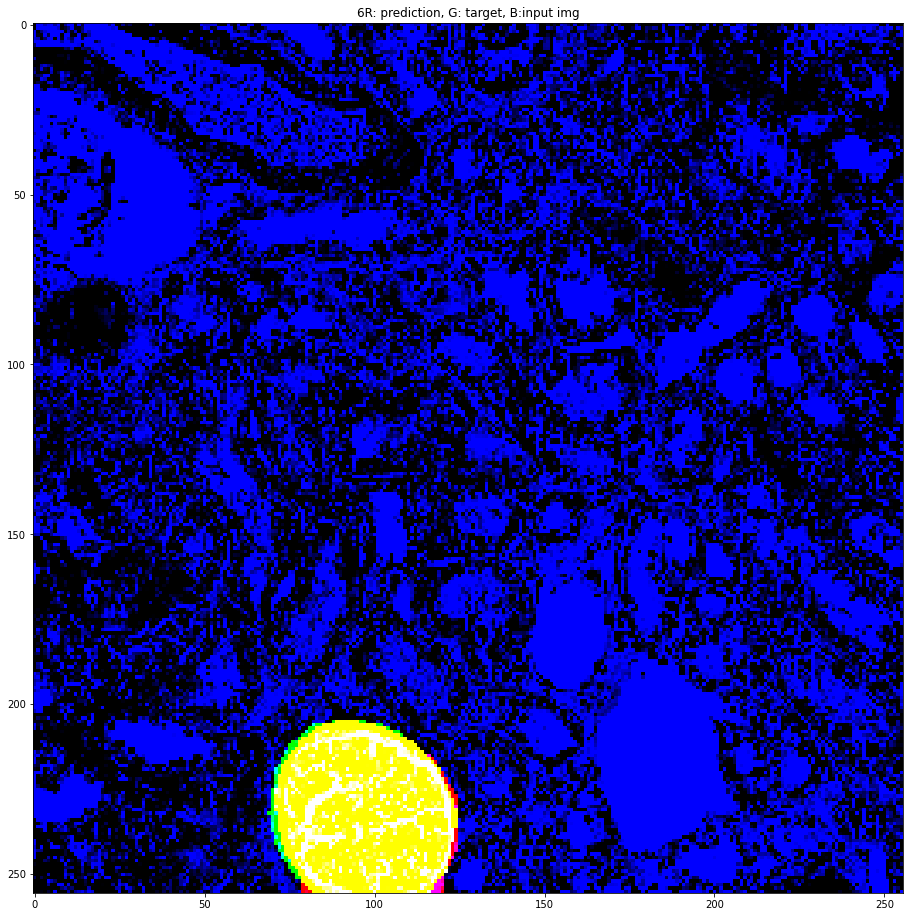

In [43]:
pred = cv2.resize(predtion, (256, 256)) #predtion.cpu().numpy() #((predtion)+img.min())/img.max()*250
print(image[0].shape)
img = image[0].cpu().numpy() #np.moveaxis(image[0], 0,-1)
img[0,:,:] = pred
img[1,:,:] = target[0][0].cpu().numpy()
img = np.transpose(img)
plt.figure(figsize=(16,16))
plt.imshow(img)
plt.title(str(i)+'R: prediction, G: target, B:input img')
plt.show()

# Evaluation on test set

In [44]:
tloss,tdice= validation(model, tloader, loss_fn)
print("test_Loss: ",tloss,"test_Dice: ",tdice)

test_Loss:  0.07948160614326315 test_Dice:  0.8207333717706069
